# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/jp/Documents/GitHub/mlfs-book
HopsworksSettings initialized!


In [33]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import pytz
from IPython.display import display


In [34]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 21, 29, 15, 967727)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [6]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']

street_list = list(location['sensor'].keys())

2025-11-18 21:17:32,529 INFO: Initializing external client
2025-11-18 21:17:32,530 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 21:17:33,116 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 21:17:34,007 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286350


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
def get_model(mr, use_more_features, sensor):
    if use_more_features:
        name = "extended_air_quality_xgboost_model"+sensor
    else:
        name = "air_quality_xgboost_model"+sensor

    retrieved_model = mr.get_model(
        name=name,
        version=1,
    )

    fv = retrieved_model.get_feature_view()

    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    return fv, saved_model_dir

In [8]:
def load_xgboost_model(saved_model_dir):

    # Loading the XGBoost regressor model and label encoder from the saved model directory
    # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

    return retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [79]:
def get_data(sensor, weather_fg, air_quality_fg, use_more_features):
    
    batch_data = weather_fg.filter(
        (weather_fg.date >= today) & (weather_fg.city == city)
    ).read()
    batch_data = batch_data.set_index('date').sort_index().reset_index()

    if use_more_features:
        # # Retrieve feature groups    
        # selected_features = air_quality_fg.select(['pm25', 'date', 'city', 'street']).join(weather_fg.select_features(), on=['city'])

        # feature_view = fs.get_or_create_feature_view(
        #     name='air_quality_fv',
        #     description="weather features with air quality as the target",
        #     version=1,
        #     labels=['pm25'],
        #     query=selected_features,
        # )
        aq_df = air_quality_fg.select(['pm25', 'date', 'city', 'street', 'country']).read()
        aq_df = aq_df[(aq_df['city'] == city) & (aq_df['street'] == sensor)]
        weather_df = weather_fg.select_all().read()
        weather_df = weather_df[weather_df['city'] == city]
        feature_view_df = aq_df.merge(weather_df, on=['city', 'date'], how='left')

        start_date = (today - pd.Timedelta(days=14)).replace(tzinfo=pytz.UTC)
        past_data = feature_view_df[feature_view_df['date'] >= start_date]

        return batch_data, aq_df, past_data
    
    else:
        return batch_data, None, None
    

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [23]:
def make_predictions(retrieved_xgboost_model, use_more_features, past_data, batch_data):
    if use_more_features:
        history = past_data.copy()        
        forecast = batch_data.copy()         
        forecast["predicted_pm25"] = 0.0

        for idx in range(len(forecast)):
            current_forecast_day = forecast.iloc[[idx]].copy()

            # Add day to forecast (t+1) to history df (t-14 days)
            df_inference = pd.concat([history, current_forecast_day], ignore_index=True)
            df_inference = make_features(df_inference)

            # Row of the day to forecast (t+1)
            forecast_date = current_forecast_day["date"].iloc[0]
            row = df_inference[df_inference["date"] == forecast_date]

            X = row[[
                'temperature_2m_mean', 
                'precipitation_sum', 
                'wind_speed_10m_max',
                'wind_direction_10m_dominant',
                'pm25_lag1',
                'pm25_lag2',
                'pm25_lag3',
                'pm25_roll3',
                'pm25_roll7',
                'pm25_roll14',
            ]]

            # Predict pm25 at t+1 (1 day)
            y_pred = retrieved_xgboost_model.predict(X)[0]

            # Store prediction in forecast
            forecast.loc[idx, "predicted_pm25"] = y_pred

            # Add prediction to history so the next day can use it
            history = pd.concat([
                history,
                pd.DataFrame({
                    "date": [forecast_date],
                    "pm25": [y_pred],
                    "temperature_2m_mean": current_forecast_day["temperature_2m_mean"].values,
                    "precipitation_sum": current_forecast_day["precipitation_sum"].values,
                    "wind_speed_10m_max": current_forecast_day["wind_speed_10m_max"].values,
                    "wind_direction_10m_dominant": current_forecast_day["wind_direction_10m_dominant"].values,
                })
            ], ignore_index=True)
        forecast["predicted_pm25"] = forecast["predicted_pm25"].astype("float32")
        batch_data = forecast

    else:
        batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    
    return batch_data, history

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
def save_predictions(batch_data, street, city, country):
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data = batch_data.sort_values(by=['date'])

    # Get or create feature group
    monitor_fg = fs.get_or_create_feature_group(
        name='aq_predictions_visby',
        description='Air Quality prediction monitoring',
        version=1,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )

    monitor_fg.insert(batch_data, wait=True)
    
    return monitor_fg, batch_data

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [101]:
def create_hindcast(use_more_features, monitor_fg, aq_df, weather_fg, retrieved_xgboost_model):
    # We will create a hindcast chart for  only the forecasts made 1 day beforehand
    monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    
    preds_df =  monitoring_df[['date', 'predicted_pm25']]

    outcome_df = aq_df[['date', 'pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, how="outer", on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    hindcast_df.dropna(inplace=True)

    if use_more_features:
        hindcast_df = make_features(hindcast_df)

        feature_columns = [
        'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max',
        'wind_direction_10m_dominant', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3',
        'pm25_roll3', 'pm25_roll7', 'pm25_roll14'
        ]
    else:
        feature_columns = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']

    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, aq_df, monitor_fg, retrieved_xgboost_model, feature_columns)
    
    #hindcast_df['predicted_pm25'] = retrieved_xgboost_model.predict(hindcast_df[feature_columns])

    return hindcast_df


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [14]:
def upload(pred_file_path, hindcast_file_path, street):
    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

---

# TESTS

In [80]:
use_more_features = True
mr = project.get_model_registry()

weather_fg = fs.get_feature_group(name='weather',version=1)
air_quality_fg = fs.get_feature_group(name='air_quality',version=1) 
sensor = 'bromsebrovag_8'

In [81]:
fv, saved_model_dir = get_model(mr, use_more_features, sensor)
retrieved_xgboost_model = load_xgboost_model(saved_model_dir)
batch_data, aq_df, past_data = get_data(sensor, weather_fg, air_quality_fg, use_more_features)
batch_data, history = make_predictions(retrieved_xgboost_model, use_more_features, past_data, batch_data)
batch_data

2025-11-18 22:06:32,758 INFO: There is no parent information


Downloading: 0.000%|          | 0/533256 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/85026 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28178 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.36s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-19 00:00:00+00:00,1.55,0.0,3.600000,360.000000,visby,31.467873
1,2025-11-20 00:00:00+00:00,1.35,0.8,6.214563,100.007919,visby,31.882626
2,2025-11-21 00:00:00+00:00,3.05,0.2,16.800856,315.000092,visby,25.459028
3,2025-11-22 00:00:00+00:00,1.95,0.0,9.726664,218.990997,visby,37.838329
4,2025-11-23 00:00:00+00:00,3.10,0.0,6.696387,233.746063,visby,29.572805
5,2025-11-24 00:00:00+00:00,3.95,0.1,10.495713,67.833611,visby,32.593864


In [83]:
batch_data['street'] = sensor
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])

# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_visby',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_visby_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286350/jobs/named/aq_predictions_visby_1_offline_fg_materialization/executions
2025-11-18 22:07:17,070 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 22:07:20,298 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 22:07:23,495 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 22:08:56,352 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 22:08:56,516 INFO: Waiting for log aggregation to finish.
2025-11-18 22:09:05,224 INFO: Execution finished successfully.


(Job('aq_predictions_visby_1_offline_fg_materialization', 'SPARK'), None)

In [88]:
aq_df

,pm25,date,city,street,country
13726,21.0,2021-08-11 00:00:00+00:00,visby,bromsebrovag_8,sweden
13730,25.0,2019-08-11 00:00:00+00:00,visby,bromsebrovag_8,sweden
13732,14.0,2021-09-02 00:00:00+00:00,visby,bromsebrovag_8,sweden
13734,21.0,2025-05-25 00:00:00+00:00,visby,bromsebrovag_8,sweden
13739,23.0,2020-09-22 00:00:00+00:00,visby,bromsebrovag_8,sweden
...,...,...,...,...,...
19478,8.0,2025-09-29 00:00:00+00:00,visby,bromsebrovag_8,sweden
19482,52.0,2025-11-09 00:00:00+00:00,visby,bromsebrovag_8,sweden
19483,41.0,2025-08-29 00:00:00+00:00,visby,bromsebrovag_8,sweden
19484,20.0,2025-10-21 00:00:00+00:00,visby,bromsebrovag_8,sweden


%6|1763500357.006|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 99746ms in state UP, 1 identical error(s) suppressed)
%6|1763500357.090|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50001ms in state UP, 1 identical error(s) suppressed)
%6|1763500407.244|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 99901ms in state UP, 1 identical error(s) suppressed)
%6|1763500407.518|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50000ms in state UP, 1 identical error(s) suppressed)
%6|1763500407.555|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50003ms in state UP, 1 identical error(s) suppressed)
%6|1763500457.736|FAIL|rdkafka#producer-7| [thrd:ssl://51.16

In [104]:
create_hindcast(use_more_features, monitor_fg, aq_df, weather_fg, retrieved_xgboost_model)

%6|1763501078.378|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 99809ms in state UP, 1 identical error(s) suppressed)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 


,date,predicted_pm25,pm25,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll7,pm25_roll14
0,2025-11-10 00:00:00+00:00,50.302071,27.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-11-10 00:00:00+00:00,19.043087,27.0,27.0,NaN,NaN,NaN,NaN,NaN
2,2025-11-11 00:00:00+00:00,29.571159,18.0,27.0,27.0,NaN,NaN,NaN,NaN
3,2025-11-11 00:00:00+00:00,25.021944,18.0,18.0,27.0,27.0,24.000000,NaN,NaN
4,2025-11-12 00:00:00+00:00,32.671028,20.0,18.0,18.0,27.0,21.000000,NaN,NaN
5,2025-11-12 00:00:00+00:00,31.396488,20.0,20.0,18.0,18.0,18.666667,NaN,NaN
6,2025-11-13 00:00:00+00:00,29.215631,35.0,20.0,20.0,18.0,19.333333,NaN,NaN
7,2025-11-13 00:00:00+00:00,24.063492,35.0,35.0,20.0,20.0,25.000000,23.571429,NaN
8,2025-11-14 00:00:00+00:00,19.717815,5.0,35.0,35.0,20.0,30.000000,24.714286,NaN
9,2025-11-14 00:00:00+00:00,28.019979,5.0,5.0,35.0,35.0,25.000000,21.571429,NaN


In [101]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    
preds_df =  monitoring_df[['date', 'predicted_pm25']]

outcome_df = aq_df[['date', 'pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, how="outer", on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 


,date,predicted_pm25,pm25
0,2017-10-04 00:00:00+00:00,NaN,13.0
1,2017-10-05 00:00:00+00:00,NaN,9.0
2,2017-10-06 00:00:00+00:00,NaN,8.0
3,2017-10-07 00:00:00+00:00,NaN,13.0
4,2017-10-08 00:00:00+00:00,NaN,8.0
...,...,...,...
2869,2025-11-15 00:00:00+00:00,NaN,4.0
2870,2025-11-16 00:00:00+00:00,NaN,7.0
2871,2025-11-17 00:00:00+00:00,NaN,5.0
2872,2025-11-18 00:00:00+00:00,NaN,6.0


In [102]:
if use_more_features:
    hindcast_df = make_features(hindcast_df)

hindcast_df

,date,predicted_pm25,pm25,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll7,pm25_roll14
0,2017-10-04 00:00:00+00:00,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10-05 00:00:00+00:00,NaN,9.0,13.0,NaN,NaN,NaN,NaN,NaN
2,2017-10-06 00:00:00+00:00,NaN,8.0,9.0,13.0,NaN,NaN,NaN,NaN
3,2017-10-07 00:00:00+00:00,NaN,13.0,8.0,9.0,13.0,10.000000,NaN,NaN
4,2017-10-08 00:00:00+00:00,NaN,8.0,13.0,8.0,9.0,10.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2869,2025-11-15 00:00:00+00:00,NaN,4.0,5.0,35.0,20.0,20.000000,32.000000,28.571429
2870,2025-11-16 00:00:00+00:00,NaN,7.0,4.0,5.0,35.0,14.666667,23.000000,28.214286
2871,2025-11-17 00:00:00+00:00,NaN,5.0,7.0,4.0,5.0,5.333333,16.571429,27.285714
2872,2025-11-18 00:00:00+00:00,NaN,6.0,5.0,7.0,4.0,5.333333,13.428571,25.928571


In [98]:
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, aq_df, monitor_fg, retrieved_xgboost_model)

hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


ValueError: feature_names mismatch: ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'pm25_roll3', 'pm25_roll7', 'pm25_roll14'] ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
expected pm25_roll14, pm25_lag2, pm25_roll3, pm25_roll7, pm25_lag1, pm25_lag3 in input data

%6|1763501351.264|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50000ms in state UP, 1 identical error(s) suppressed)


2025-11-18 22:29:11,642 INFO: There is no parent information


%6|1763501352.587|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50000ms in state UP, 1 identical error(s) suppressed)


Downloading: 0.000%|          | 0/533256 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/85026 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28178 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.41s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 






Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_visby_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286350/jobs/named/aq_predictions_visby_1_offline_fg_materialization/executions
2025-11-18 22:29:36,076 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 22:29:39,275 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763501380.782|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 100228ms in state UP, 1 identical error(s) suppressed)
%6|1763501401.711|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50001ms in state UP, 1 identical error(s) suppressed)
%6|1763501402.712|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 99682ms in state UP, 1 identical error(s) suppressed)
%6|1763501431.275|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50013ms in state UP, 1 identical error(s) suppressed)
%6|1763501451.836|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 99729ms in state UP, 1 identical error(s) suppressed)
%6|1763501453.171|FAIL|rdkafka#producer-5| [thrd:ssl://51.1

2025-11-18 22:31:05,800 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 22:31:05,957 INFO: Waiting for log aggregation to finish.
2025-11-18 22:31:14,787 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/bromsebrovag_8/pm25_forecast.png: 0…

Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/bromsebrovag_8/pm25_hindcast_1day.p…

%6|1763501481.809|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50003ms in state UP, 1 identical error(s) suppressed)


See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286350/settings/fb/path/Resources/airquality

 Sensor bromsebrovag_8 has been run and uploaded correctly! 

2025-11-18 22:31:24,259 INFO: There is no parent information


Downloading: 0.000%|          | 0/533256 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/82458 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28178 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 






Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_visby_1_offline_fg_materialization


%6|1763501502.350|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50002ms in state UP, 1 identical error(s) suppressed)
%6|1763501502.448|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 50004ms in state UP, 1 identical error(s) suppressed)
%6|1763501503.302|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 99912ms in state UP, 1 identical error(s) suppressed)


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286350/jobs/named/aq_predictions_visby_1_offline_fg_materialization/executions
2025-11-18 22:31:49,050 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 22:31:55,461 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


%6|1763501531.939|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 99743ms in state UP, 1 identical error(s) suppressed)
%6|1763501552.926|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50002ms in state UP, 1 identical error(s) suppressed)
%6|1763501553.755|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 49997ms in state UP, 1 identical error(s) suppressed)
%6|1763501582.431|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 50001ms in state UP, 1 identical error(s) suppressed)


2025-11-18 22:33:15,732 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 22:33:15,886 INFO: Waiting for log aggregation to finish.


%6|1763501603.112|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 100163ms in state UP, 1 identical error(s) suppressed)
%6|1763501604.260|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 49998ms in state UP, 1 identical error(s) suppressed)


2025-11-18 22:33:24,493 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/ostervag_17/pm25_forecast.png: 0.00…

Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/ostervag_17/pm25_hindcast_1day.png:…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286350/settings/fb/path/Resources/airquality

 Sensor ostervag_17 has been run and uploaded correctly! 



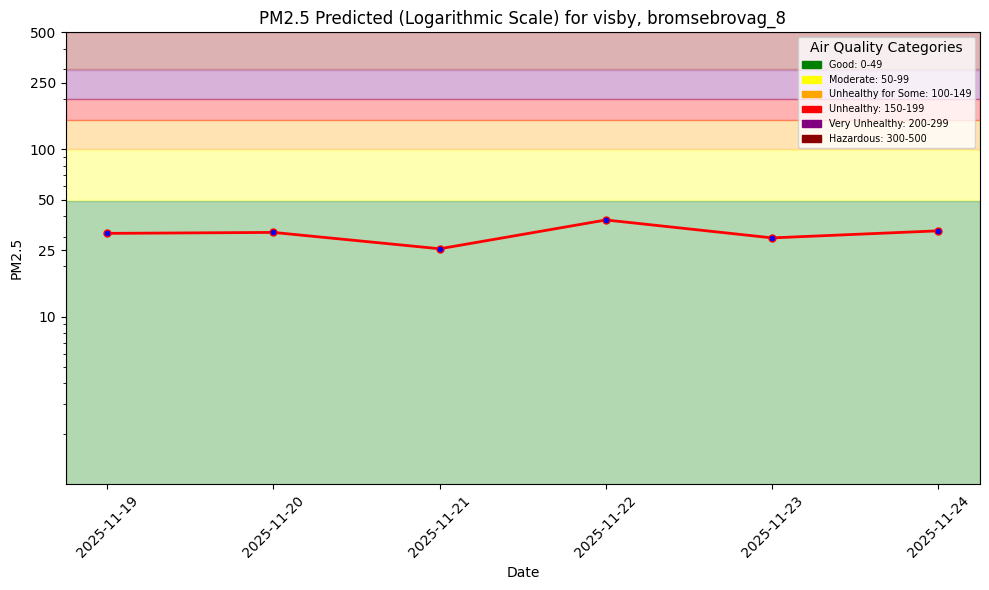

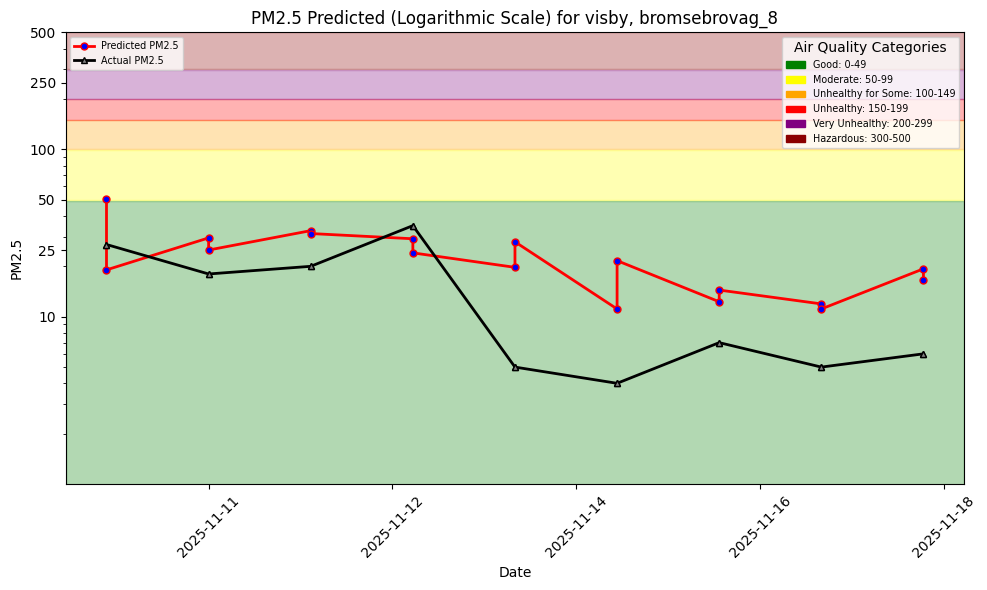

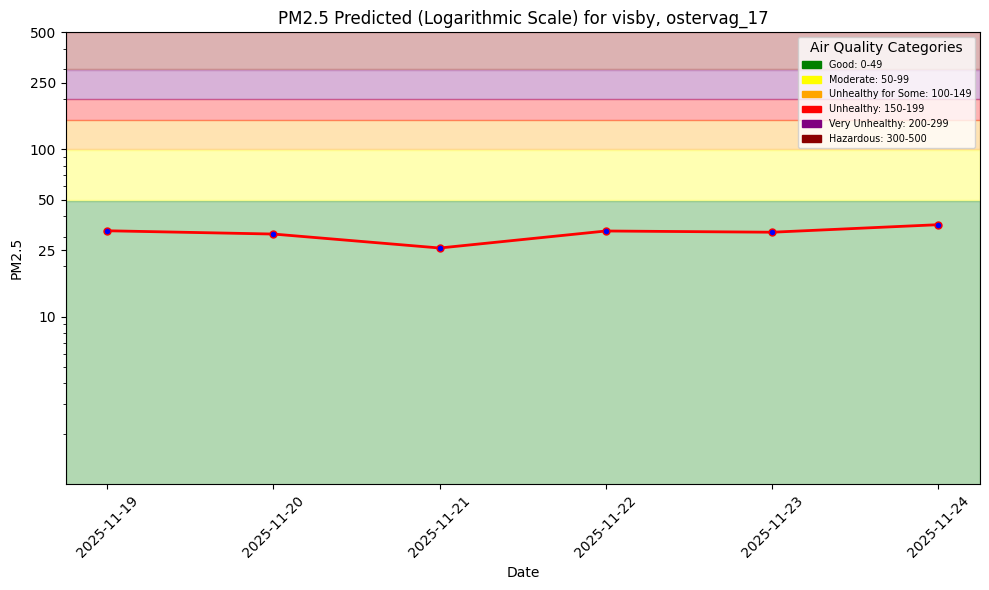

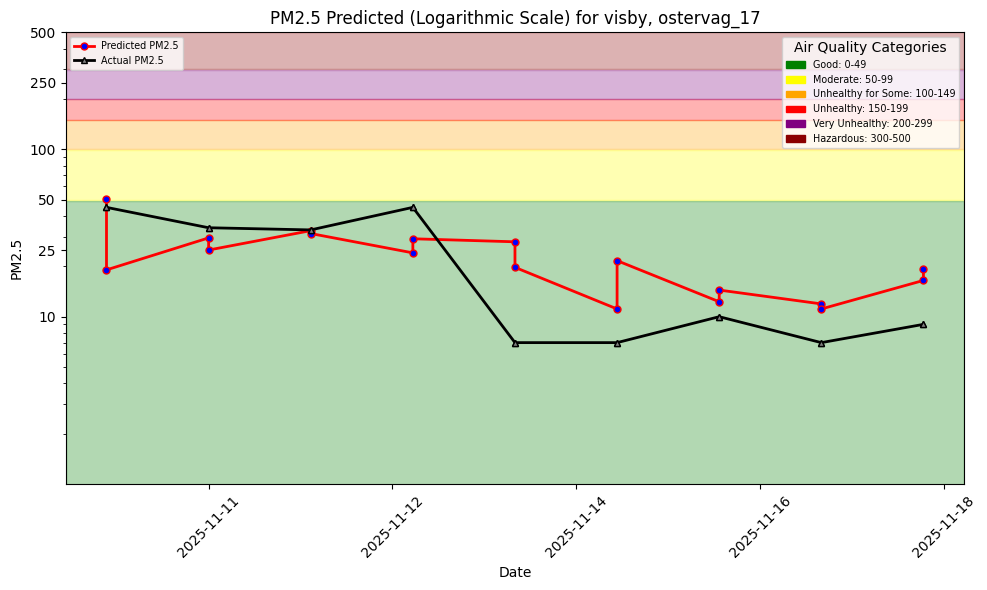

%6|1763501653.695|FAIL|rdkafka#producer-7| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50110ms in state UP, 1 identical error(s) suppressed)
%6|1763501654.818|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 50103ms in state UP, 1 identical error(s) suppressed)
%6|1763501670.283|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.81.208:9093/bootstrap]: ssl://51.161.81.208:9093/2: Disconnected (after 137721ms in state UP, 1 identical error(s) suppressed)
%6|1763501704.966|FAIL|rdkafka#producer-5| [thrd:ssl://51.161.80.189:9093/bootstrap]: ssl://51.161.80.189:9093/0: Disconnected (after 99825ms in state UP, 1 identical error(s) suppressed)
%6|1763501720.802|FAIL|rdkafka#producer-9| [thrd:ssl://51.161.81.188:9093/bootstrap]: ssl://51.161.81.188:9093/1: Disconnected (after 49998ms in state UP, 1 identical error(s) suppressed)
%6|1763501749.746|FAIL|rdkafka#producer-7| [thrd:ssl://51.1

In [ ]:
use_more_features = True
mr = project.get_model_registry()

weather_fg = fs.get_feature_group(name='weather',version=1)
air_quality_fg = fs.get_feature_group(name='air_quality',version=1) 

for sensor in street_list:
#for sensor in ['bromsebrovag_8']:
    weather_fg.filter(weather_fg.city == sensor)  
    fv, saved_model_dir = get_model(mr, use_more_features, sensor)
    retrieved_xgboost_model = load_xgboost_model(saved_model_dir)

    batch_data, aq_df, past_data = get_data(sensor, weather_fg, air_quality_fg, use_more_features)
    batch_data, history = make_predictions(retrieved_xgboost_model, use_more_features, past_data, batch_data)
    monitor_fg, batch_data = save_predictions(batch_data, sensor, city, country)

    # Create dir to save results
    sensor_dir = f"{root_dir}/docs/air-quality/assets/img/{sensor}"
    os.makedirs(sensor_dir, exist_ok=True)

    # Createpredictions
    pred_file_path = f"{sensor_dir}/pm25_forecast.png"
    util.plot_air_quality_forecast(city, sensor, batch_data, pred_file_path)
    
    # Create hindcasts
    hindcast_file_path = f"{sensor_dir}/pm25_hindcast_1day.png"
    hindcast_df = create_hindcast(use_more_features, monitor_fg, aq_df, weather_fg, retrieved_xgboost_model)
    util.plot_air_quality_forecast(city, sensor, hindcast_df, hindcast_file_path, hindcast=True)

    # Upload pictures
    upload(pred_file_path, hindcast_file_path, sensor)

    print('\n Sensor ' + sensor + ' has been run and uploaded correctly! \n')
    